In [2]:
!pip install sklearn-crfsuite

In [3]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pylab as plt
import seaborn as sns
import nltk

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
from sklearn_crfsuite import CRF, metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
#Reading the data
df = pd.read_csv('preprocess_result.csv')
df.head()

,unique_id,statement,status
0,34234,fear of get schizophrenia or ani mental ill so...,Anxiety
1,34691,my mind is trick me into feel like i need to u...,Anxiety
2,35451,dont know what wrong with me i realli ca n't b...,Anxiety
3,51950,a remind that progress is n't linear and that ...,Anxiety
4,52587,just had one of the worst anxieti attack of my...,Anxiety


In [5]:
print(df.columns)

Index(['unique_id', 'statement', 'status'], dtype='object')


In [6]:
# Melihat jumlah data per kelas
print("Jumlah data per kelas:")
print(df['status'].value_counts())

# Jumlah keseluruhan data
print("\nJumlah keseluruhan data:")
print(df['status'].value_counts().sum())

Jumlah data per kelas:
status
Anxiety                 895
Normal                  895
Depression              895
Suicidal                895
Stress                  895
Bipolar                 895
Personality disorder    895
Name: count, dtype: int64

Jumlah keseluruhan data:
6265


In [7]:
x = df['statement']
y = df['status']

In [8]:
lbl_enc = LabelEncoder()
y_encoded = lbl_enc.fit_transform(y)

In [9]:
#strcutural feature
def extract_structural_features(df, text_column='statement'):
    """
    Ekstraksi fitur struktural dari text_column dalam dataframe df.

    Menghasilkan DataFrame dengan fitur:
    - x1: jumlah kata
    - x2: jumlah kalimat
    - x3: jumlah karakter khusus
    """
    features = {
        'x1': [],  # jumlah kata
        'x2': [],  # jumlah kalimat
        'x3': []   # jumlah karakter khusus
    }

    for text in df[text_column]:
        if pd.isna(text):
            features['x1'].append(0)
            features['x2'].append(0)
            features['x3'].append(0)
            continue

        text = str(text)

        # Hitung jumlah kata
        words = re.findall(r'\b\w+\b', text)

        # Hitung jumlah kalimat
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if s.strip()]

        # Hitung jumlah karakter khusus
        special_chars = re.findall(r'[^\w\s]', text)

        features['x1'].append(len(words))
        features['x2'].append(len(sentences))
        features['x3'].append(len(special_chars))

    return pd.DataFrame(features)

In [12]:
#syntactic feature (pos tagging)
# 1. Mendapatkan "Ground Truth" Awal untuk Pelatihan CRF ---
# menggunakan NLTK's default tagger sebagai proxy untuk ground truth, karena CRF model supervised dan butuh label untuk belajar.
def get_initial_pos_tags(text):
    if pd.isna(text) or not text.strip(): # Cek jika NaN atau string kosong/hanya whitespace
        return []
    try:
        tokens = word_tokenize(str(text))
        return nltk.pos_tag(tokens) # Gunakan NLTK tagger untuk mendapatkan initial tags
    except Exception as e:
        print(f"Error getting initial tags for text: {text} -> {e}")
        return []

df['initial_pos_tags'] = df['statement'].apply(get_initial_pos_tags)

# 2. Ekstraksi Fitur untuk CRF
# Fungsi akan mengekstrak fitur dari setiap kata dalam sebuah kalimat.
# Fitur-fitur ini akan digunakan oleh model CRF untuk memprediksi POS tag.
def word2features(sent, i):
    word, tag = sent[i] # Word dan tag dari initial_pos_tags (yang akan digunakan sebagai label pelatihan)
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:], # Akhiran 3 huruf
        'word[-2:]': word[-2:], # Akhiran 2 huruf
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': tag, # POS tag NLTK dari ground truth awal (ini adalah fitur kuat!)
        'postag[:2]': tag[:2], # Dua huruf pertama dari POS tag
    }
    if i > 0:
        word1, tag1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': tag1,
            '-1:postag[:2]': tag1[:2],
        })
    else:
        features['BOS'] = True # Beginning Of Sentence

    if i < len(sent)-1:
        word1, tag1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': tag1,
            '+1:postag[:2]': tag1[:2],
        })
    else:
        features['EOS'] = True # End Of Sentence
    return features

# Fungsi untuk mendapatkan daftar fitur dari seluruh kalimat
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# Fungsi untuk mendapatkan daftar label (POS tag) dari seluruh kalimat
def sent2labels(sent):
    return [label for token, label in sent]

# Siapkan data dalam format yang dibutuhkan CRF untuk pelatihan
# X akan berisi fitur, y akan berisi label
X = [sent2features(s) for s in df['initial_pos_tags'] if s] # Filter kalimat kosong
y = [sent2labels(s) for s in df['initial_pos_tags'] if s] # Filter kalimat kosong

# 3. Melatih Model CRF Sekali pada Seluruh Data
# pada seluruh data yang tersedia untuk menghasilkan tagger yang robust.
if not X or not y:
    print("Warning: No valid data found for CRF training. Please check 'initial_pos_tags' column.")
    # Jika tidak ada data, DataFrame fitur akan kosong
    df_pos_features = pd.DataFrame()
else:
    crf = CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )

    crf.fit(X, y)

    # 4. Menggunakan Model CRF yang Sudah Dilatih untuk Mendapatkan POS Tagging di DataFrame
    # Fungsi ini akan melakukan prediksi POS tagging dengan model CRF pada teks baru.
    def predict_pos_with_crf(crf_model, text_input):
        if pd.isna(text_input) or not text_input.strip():
            return []
        tokens = word_tokenize(str(text_input))

        # Untuk prediksi, kita hanya punya kata, jadi kita buat dummy tag
        dummy_sent_for_prediction = [(token, "DUMMY_TAG") for token in tokens]
        features_for_prediction = sent2features(dummy_sent_for_prediction)

        if not features_for_prediction:
            return []

        predicted_tags = crf_model.predict([features_for_prediction])[0]
        return list(zip(tokens, predicted_tags))

    # Terapkan model CRF ke seluruh kolom statement
    df['crf_pos_tags'] = df['statement'].apply(lambda x: predict_pos_with_crf(crf, x))

    # 5. Ekstraksi hanya POS tags tanpa kata (dari hasil CRF)
    exclude_tags_for_features = {
        '.', ',', ':', '`', "''", '(', ')', '--', '$', '#', 'SYM',
    }

    df['pos_only_crf'] = df['crf_pos_tags'].apply(
        lambda x: [tag for _, tag in x if tag not in exclude_tags_for_features]
    )

    # # 6. Count Encoding menggunakan Counter (Hitung frekuensi POS tags)
    # df['pos_count_crf'] = df['pos_only_crf'].apply(lambda tags: dict(Counter(tags)))
    # # Ubah dict ke DataFrame
    # df_pos_features = pd.json_normalize(df['pos_count_crf']).fillna(0).astype(int)
    # # Tambahkan prefix agar kolom POS jelas
    # df_pos_features.columns = ['POS_' + col for col in df_pos_features.columns]

In [13]:
# semantic feature
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    min_df=0.04, # Kata yang muncul di ≥4% dokumen,
    sublinear_tf=True, # Gunakan log-scaling untuk TF
    ngram_range=(1,1),  # Unigram dan Bigram
    max_features=3000,
    norm='l2' # Normalisasi L2
)
features_tfidf = tfidf_vectorizer.fit_transform(x)

# CountVectorizer N-Gram
ngram_vectorizer = CountVectorizer(
    ngram_range=(2,2),
    max_features=3000, # Batasi jumlah fitur
    min_df=2,
    max_df=0.9
)
features_ngram = ngram_vectorizer.fit_transform(x)

# Ekstrak fitur struktural
structural_features = extract_structural_features(df)

# Syntactic Features
df['pos_only_crf'] = df['crf_pos_tags'].apply(lambda x: [tag for _, tag in x if tag not in exclude_tags_for_features])
df['pos_count_crf'] = df['pos_only_crf'].apply(lambda tags: dict(Counter(tags)))
df_pos_features = pd.json_normalize(df['pos_count_crf']).fillna(0).astype(int)
df_pos_features.columns = ['POS_' + col for col in df_pos_features.columns]

# Gabungkan semantic, Structural, syntactic
semantic_features = hstack([features_tfidf, features_ngram])
semantic_array = semantic_features.toarray()
syntactic_array = df_pos_features.values
structural_array = structural_features.values
final_features_array = np.hstack([semantic_array, syntactic_array, structural_array,])

# kolom Nama-nama fitur
feature_tfidf = ["TFIDF_" + f for f in tfidf_vectorizer.get_feature_names_out()]
feature_ngram = ["NGRAM_" + f for f in ngram_vectorizer.get_feature_names_out()]
feature_syntactic = list(df_pos_features.columns)
feature_structural = ["STR_" + col for col in structural_features.columns]

feature_combined = feature_tfidf + feature_ngram + feature_syntactic + feature_structural

# Buat DataFrame akhir
final_features = pd.DataFrame(final_features_array, columns=feature_combined)

# Tambahkan kolom ID
final_features = pd.concat([
    df[['unique_id']].reset_index(drop=True),
    final_features
], axis=1)

# Simpan ke CSV
final_features.to_csv('SM_SYN_STR_feature.csv', index=False)
print("DataFrame berhasil disimpan ke 'SM_SYN_STR_feature.csv'")

# Tampilkan contoh
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
final_features.head(5)

DataFrame berhasil disimpan ke 'SM_SYN_STR_feature.csv'


unique_id  TFIDF_abl  TFIDF_about  TFIDF_actual  TFIDF_advic  TFIDF_after  TFIDF_again  TFIDF_ago  TFIDF_all  TFIDF_almost  TFIDF_alon  TFIDF_alreadi  TFIDF_also  TFIDF_alway  TFIDF_am  TFIDF_an  TFIDF_and  TFIDF_ani  TFIDF_anoth  TFIDF_anxieti  TFIDF_anxiou  TFIDF_anymor  TFIDF_anyon  TFIDF_anyth  TFIDF_anyway  TFIDF_are  TFIDF_around  TFIDF_as  TFIDF_ask  TFIDF_at  TFIDF_attack  TFIDF_avoid  TFIDF_avpd  TFIDF_away  TFIDF_back  TFIDF_bad  TFIDF_be  TFIDF_becaus  TFIDF_becom  TFIDF_been  TFIDF_befor  TFIDF_believ  TFIDF_best  TFIDF_better  TFIDF_bipolar  TFIDF_bit  TFIDF_bodi  TFIDF_brain  TFIDF_but  TFIDF_by  TFIDF_ca  TFIDF_call  TFIDF_can  TFIDF_care  TFIDF_caus  TFIDF_chang  TFIDF_close  TFIDF_come  TFIDF_complet  TFIDF_could  TFIDF_cri  TFIDF_current  TFIDF_day  TFIDF_deal  TFIDF_depress  TFIDF_diagnos  TFIDF_did  TFIDF_die  TFIDF_differ  TFIDF_disord  TFIDF_do  TFIDF_doctor  TFIDF_doe  TFIDF_don  TFIDF_done  TFIDF_down  TFIDF_due  TFIDF_dure  TFIDF_eat  TFIDF_either  TFIDF_els  TFIDF_emot  TFIDF_end  TFIDF_enough  TFIDF_episod  TFIDF_etc  TFIDF_even  TFIDF_ever  TFIDF_everi  TFIDF_everyon  TFIDF_everyth  TFIDF_experi  TFIDF_extrem  TFIDF_famili  TFIDF_fear  TFIDF_feel  TFIDF_felt  TFIDF_few  TFIDF_final  TFIDF_find  TFIDF_fine  TFIDF_first  TFIDF_for  TFIDF_found  TFIDF_friend  TFIDF_from  TFIDF_fuck  TFIDF_get  TFIDF_give  TFIDF_go  TFIDF_gone  TFIDF_good  TFIDF_got  TFIDF_great  TFIDF_guess  TFIDF_guy  TFIDF_ha  TFIDF_had  TFIDF_happen  TFIDF_happi  TFIDF_hard  TFIDF_hate  TFIDF_have  TFIDF_he  TFIDF_head  TFIDF_health  TFIDF_heart  TFIDF_help  TFIDF_her  TFIDF_here  TFIDF_hi  TFIDF_high  TFIDF_him  TFIDF_home  TFIDF_hope  TFIDF_hour  TFIDF_hous  TFIDF_how  TFIDF_hurt  TFIDF_idea  TFIDF_if  TFIDF_ill  TFIDF_in  TFIDF_into  TFIDF_is  TFIDF_issu  TFIDF_it  TFIDF_job  TFIDF_just  TFIDF_keep  TFIDF_kill  TFIDF_kind  TFIDF_know  TFIDF_last  TFIDF_late  TFIDF_least  TFIDF_leav  TFIDF_left  TFIDF_let  TFIDF_life  TFIDF_like  TFIDF_liter  TFIDF_littl  TFIDF_live  TFIDF_ll  TFIDF_long  TFIDF_look  TFIDF_lose  TFIDF_lost  TFIDF_lot  TFIDF_love  TFIDF_made  TFIDF_make  TFIDF_mani  TFIDF_matter  TFIDF_mayb  TFIDF_me  TFIDF_mean  TFIDF_med  TFIDF_medic  TFIDF_mental  TFIDF_might  TFIDF_mind  TFIDF_mom  TFIDF_money  TFIDF_month  TFIDF_more  TFIDF_most  TFIDF_move  TFIDF_much  TFIDF_my  TFIDF_myself  TFIDF_need  TFIDF_never  TFIDF_new  TFIDF_next  TFIDF_night  TFIDF_no  TFIDF_normal  TFIDF_not  TFIDF_noth  TFIDF_now  TFIDF_of  TFIDF_off  TFIDF_old  TFIDF_on  TFIDF_onc  TFIDF_one  TFIDF_onli  TFIDF_or  TFIDF_other  TFIDF_our  TFIDF_out  TFIDF_over  TFIDF_own  TFIDF_pain  TFIDF_panic  TFIDF_parent  TFIDF_part  TFIDF_past  TFIDF_peopl  TFIDF_person  TFIDF_place  TFIDF_pleas  TFIDF_point  TFIDF_possibl  TFIDF_post  TFIDF_pretti  TFIDF_probabl  TFIDF_problem  TFIDF_put  TFIDF_quit  TFIDF_re  TFIDF_read  TFIDF_real  TFIDF_realli  TFIDF_reason  TFIDF_recent  TFIDF_relat  TFIDF_relationship  TFIDF_rememb  TFIDF_right  TFIDF_sad  TFIDF_said  TFIDF_same  TFIDF_say  TFIDF_scare  TFIDF_school  TFIDF_see  TFIDF_seem  TFIDF_self  TFIDF_sever  TFIDF_she  TFIDF_shit  TFIDF_should  TFIDF_sick  TFIDF_side  TFIDF_sinc  TFIDF_situat  TFIDF_sleep  TFIDF_so  TFIDF_social  TFIDF_some  TFIDF_someon  TFIDF_someth  TFIDF_sometim  TFIDF_sorri  TFIDF_start  TFIDF_stay  TFIDF_still  TFIDF_stop  TFIDF_stress  TFIDF_struggl  TFIDF_such  TFIDF_suffer  TFIDF_suicid  TFIDF_sure  TFIDF_symptom  TFIDF_take  TFIDF_talk  TFIDF_tell  TFIDF_than  TFIDF_thank  TFIDF_that  TFIDF_the  TFIDF_their  TFIDF_them  TFIDF_then  TFIDF_therapi  TFIDF_therapist  TFIDF_there  TFIDF_these  TFIDF_they  TFIDF_thi  TFIDF_thing  TFIDF_think  TFIDF_those  TFIDF_though  TFIDF_thought  TFIDF_through  TFIDF_time  TFIDF_tire  TFIDF_to  TFIDF_today  TFIDF_told  TFIDF_too  TFIDF_took  TFIDF_tri  TFIDF_turn  TFIDF_two  TFIDF_understand  TFIDF_until  TFIDF_up  TFIDF_use  TFIDF_usual  TFIDF_ve  TFIDF_veri  TFIDF_wa  TFIDF_want  TFIDF_way  TFIDF_we  TFIDF_week  TFIDF_well  TFIDF_went  TFIDF_were  TFIDF

In [14]:
# Pisahkan fitur (X) dan label (y)
X = final_features.drop(['unique_id'], axis=1)
# y = final_features['status']

In [15]:
xgb.set_config(verbosity=2)

# Model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(lbl_enc.classes_),
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    n_jobs=1  # untuk menghindari konflik paralel saat pakai GPU
)

# Cross Validation Prediction
y_pred_cv = cross_val_predict(xgb_model, final_features_array, y_encoded, cv=5)

# Evaluasi
print("Classification Report (Cross-Validation):")
print(classification_report(y_encoded, y_pred_cv, target_names=lbl_enc.classes_))
print("F1 Score:", f1_score(y_encoded, y_pred_cv, average='macro'))
print("Accuracy:", accuracy_score(y_encoded, y_pred_cv))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:22:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Classification Report (Cross-Validation):
                      precision    recall  f1-score   support

             Anxiety       0.76      0.72      0.74       895
             Bipolar       0.78      0.73      0.76       895
          Depression       0.67      0.58      0.62       895
              Normal       0.78      0.84      0.81       895
Personality disorder       0.75      0.77      0.76       895
              Stress       0.72      0.78      0.75       895
            Suicidal       0.64      0.67      0.65       895

            accuracy                           0.73      6265
           macro avg       0.73      0.73      0.73      6265
        weighted avg       0.73      0.73      0.73      6265

F1 Score: 0.7266942539857743
Accuracy: 0.727853152434158


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.657 total time=   5.0s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.678 total time=   4.5s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.674 total time=   3.8s
[CV 4/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.675 total time=   4.0s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.694 total time=   4.3s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=150;, score=0.663 total time=   5.1s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=150;, score=0.681 total time=   5.3s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=150;, score=0.679 total time= 

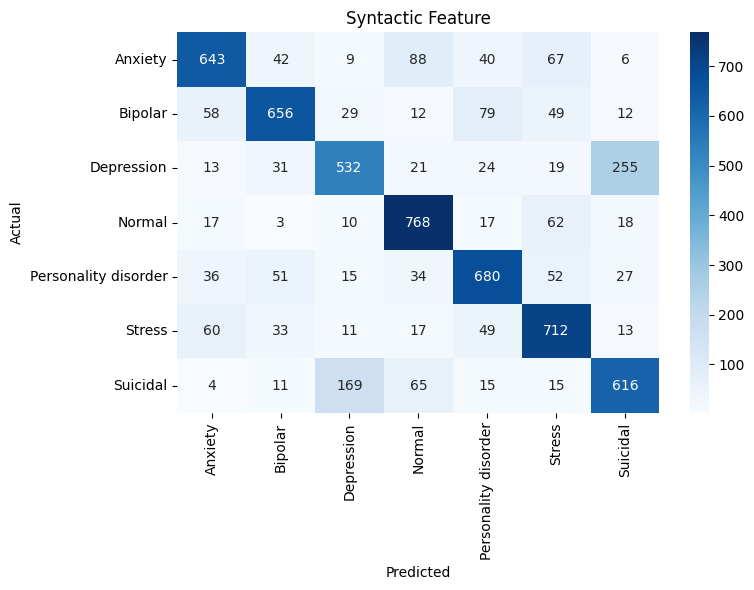


Akurasi Tiap Fold:
Fold 1: 0.7079
Fold 2: 0.7334
Fold 3: 0.7446
Fold 4: 0.7334
Fold 5: 0.7574

Rata-rata Akurasi Cross-Validation: 0.7354

Total waktu eksekusi: 162.21 menit


In [16]:
# Penerapan GridSearchCV (utk menemukan kombinasi parameter terbaik)
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [100, 150, 200, 250],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # Cross-validation 5-fold
    n_jobs=1,
    verbose=3  # Menampilkan progress tuning
)

# Mengukur waktu eksekusi
start_time = time.time()

# Training GridSearchCV
# grid_search.fit(X, y)
grid_search.fit(final_features_array, y_encoded)

elapsed_time = time.time() - start_time
elapsed_time_minutes = elapsed_time / 60

# --- Hyperparameter Terbaik ---
best_params_df = pd.DataFrame(grid_search.best_params_.items(), columns=["Hyperparameter", "Best Value"])
print("\nBest Hyperparameters:")
print(best_params_df.to_string(index=False))

# --- Akurasi Terbaik dari GridSearchCV ---
print(f"\nBest Accuracy from GridSearchCV: {grid_search.best_score_:.4f}")

# --- Prediksi Model Terbaik ---
best_model = grid_search.best_estimator_
y_pred_cv = cross_val_predict(best_model, final_features_array, y_encoded, cv=5)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_encoded, y_pred_cv, target_names=lbl_enc.classes_))

# --- Confusion Matrix  ---
cm = confusion_matrix(y_encoded, y_pred_cv)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.title('Syntactic Feature')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# --- Akurasi Tiap Fold ---
cv_results = pd.DataFrame(grid_search.cv_results_)
best_index = grid_search.best_index_
fold_scores = [cv_results[f"split{i}_test_score"][best_index] for i in range(grid_search.cv)]

print("\nAkurasi Tiap Fold:")
for i, score in enumerate(fold_scores):
    print(f"Fold {i+1}: {score:.4f}")
print(f"\nRata-rata Akurasi Cross-Validation: {np.mean(fold_scores):.4f}")

# Total waktu
print(f"\nTotal waktu eksekusi: {elapsed_time_minutes:.2f} menit")